# CNN Fish Image Classification - Complete Implementation

**Dataset:** FishImgDataset  
**Objective:** End-to-end pipeline for fish species classification using CNN  
**Author:** Michael Christopher
**Date:** June 2025

## Table of Contents
1. [Introduction and Theory](#1-introduction-and-theory)
2. [Dataset Import and Setup](#2-dataset-import-and-setup)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Feature Engineering and Preprocessing](#4-feature-engineering-and-preprocessing)
5. [CNN Theory and Mathematical Foundation](#5-cnn-theory-and-mathematical-foundation)
6. [Model Implementation - TensorFlow/Keras](#6-model-implementation---tensorflowkeras)
7. [Model Implementation - PyTorch](#7-model-implementation---pytorch)
8. [Model Evaluation and Comparison](#8-model-evaluation-and-comparison)
9. [Results Interpretation](#9-results-interpretation)
10. [Conclusion](#10-conclusion)

## 1. Introduction and Theory

### What is a Convolutional Neural Network (CNN)?

A **Convolutional Neural Network (CNN)** is a specialized type of neural network designed for processing grid-like data such as images. CNNs are particularly effective for image classification, object detection, and computer vision tasks.

### Key Components of CNN:

1. **Convolutional Layer**: Applies filters to detect features
2. **Pooling Layer**: Reduces spatial dimensions
3. **Fully Connected Layer**: Final classification layer
4. **Activation Functions**: Introduce non-linearity

### Mathematical Foundation:

**Convolution Operation:**
```
(f * g)(t) = ∫ f(τ)g(t - τ)dτ
```

For discrete 2D convolution (images):
```
(I * K)(i,j) = ΣΣ I(m,n)K(i-m, j-n)
```

Where:
- I = Input image
- K = Kernel/Filter
- * = Convolution operation

**Pooling Operation (Max Pooling):**
```
P(i,j) = max(I(i:i+k, j:j+k))
```

**Activation Function (ReLU):**
```
ReLU(x) = max(0, x)
```

**Softmax for Classification:**
```
σ(z_i) = e^(z_i) / Σ(e^(z_j)) for j = 1...K
```

## 2. Dataset Import and Setup

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

# Image Processing
from PIL import Image
import cv2
from glob import glob

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")

All libraries imported successfully!
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124


In [2]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')
import zipfile
# Path to your zip file in Drive
zip_path = '/content/drive/MyDrive/FishImgDataset.zip'  # Replace with your actual path

# Extract to current directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Dataset paths - adjust these paths according to your Google Drive structure
# The main dataset folder (extracted from zip)
DATASET_PATH = '/content/FishImgDataset'  # This is the folder that was inside the zip

# Subfolders for train, val, test
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Verify the structure
print("Dataset folder contents:", os.listdir(DATASET_PATH))
print("Train folder contents:", os.listdir(TRAIN_PATH)[:5])  # Show first 5 items
print("Val folder contents:", os.listdir(VAL_PATH)[:5])
print("Test folder contents:", os.listdir(TEST_PATH)[:5])
# Alternative local paths (if not using Google Drive)
# DATASET_PATH = '/content/FishImgDataset'
# TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
# VAL_PATH = os.path.join(DATASET_PATH, 'val')
# TEST_PATH = os.path.join(DATASET_PATH, 'test')

print(f"Dataset path: {DATASET_PATH}")
print(f"Train path: {TRAIN_PATH}")
print(f"Validation path: {VAL_PATH}")
print(f"Test path: {TEST_PATH}")

Mounted at /content/drive
Dataset folder contents: ['test', 'val', 'train']
Train folder contents: ['Silver Carp', 'Long-Snouted Pipefish', 'Tilapia', 'Silver Barb', 'Mosquito Fish']
Val folder contents: ['Silver Carp', 'Long-Snouted Pipefish', 'Tilapia', 'Silver Barb', 'Mosquito Fish']
Test folder contents: ['Silver Carp', 'Long-Snouted Pipefish', 'Tilapia', 'Silver Barb', 'Mosquito Fish']
Dataset path: /content/FishImgDataset
Train path: /content/FishImgDataset/train
Validation path: /content/FishImgDataset/val
Test path: /content/FishImgDataset/test


## 3. Exploratory Data Analysis (EDA)

In [3]:
def explore_dataset_structure(dataset_path, split_name):
    """
    Explore the dataset structure and provide detailed information

    Args:
        dataset_path (str): Path to the dataset split
        split_name (str): Name of the split (train/val/test)

    Returns:
        tuple: (classes, class_counts)
    """
    print("="*60)
    print(f"DATASET EXPLORATION - {split_name.upper()}")
    print("="*60)

    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return None, None

    # Get all subdirectories (classes)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    classes.sort()

    print(f"Found {len(classes)} classes: {classes}")

    # Count images per class
    class_counts = {}
    total_images = 0

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, '*.jpg')) + \
                     glob(os.path.join(class_path, '*.jpeg')) + \
                     glob(os.path.join(class_path, '*.png'))
        class_counts[class_name] = len(image_files)
        total_images += len(image_files)

    print(f"\nTotal images: {total_images}")
    print("\nImages per class:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")

    return classes, class_counts

# Explore each dataset split
train_classes, train_counts = explore_dataset_structure(TRAIN_PATH, 'train')
val_classes, val_counts = explore_dataset_structure(VAL_PATH, 'validation')
test_classes, test_counts = explore_dataset_structure(TEST_PATH, 'test')

DATASET EXPLORATION - TRAIN
Found 31 classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

Total images: 8672

Images per class:
  Bangus: 171 images
  Big Head Carp: 201 images
  Black Spotted Barb: 200 images
  Catfish: 314 images
  Climbing Perch: 151 images
  Fourfinger Threadfin: 191 images
  Freshwater Eel: 271 images
  Glass Perchlet: 397 images
  Goby: 604 images
  Gold Fish: 201 images
  Gourami: 311 images
  Grass Carp: 1167 images
  Green Spotted Puffer: 110 images
  Indian Carp: 243 images
  Indo-Pacific Tarpon: 186 images
  Jaguar Gapote: 229 images


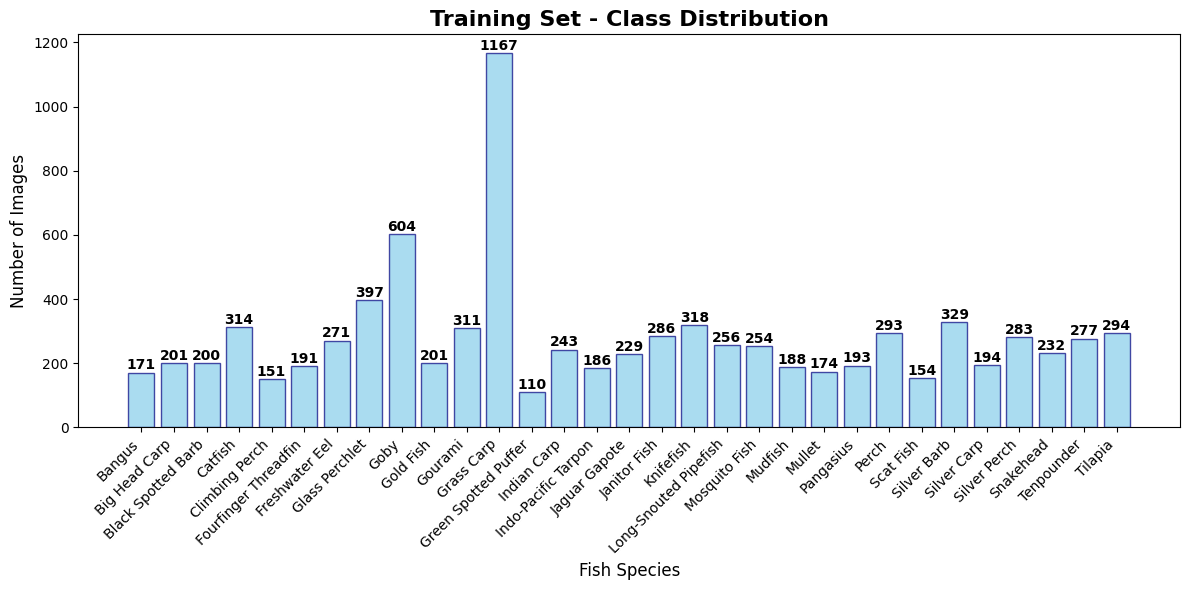

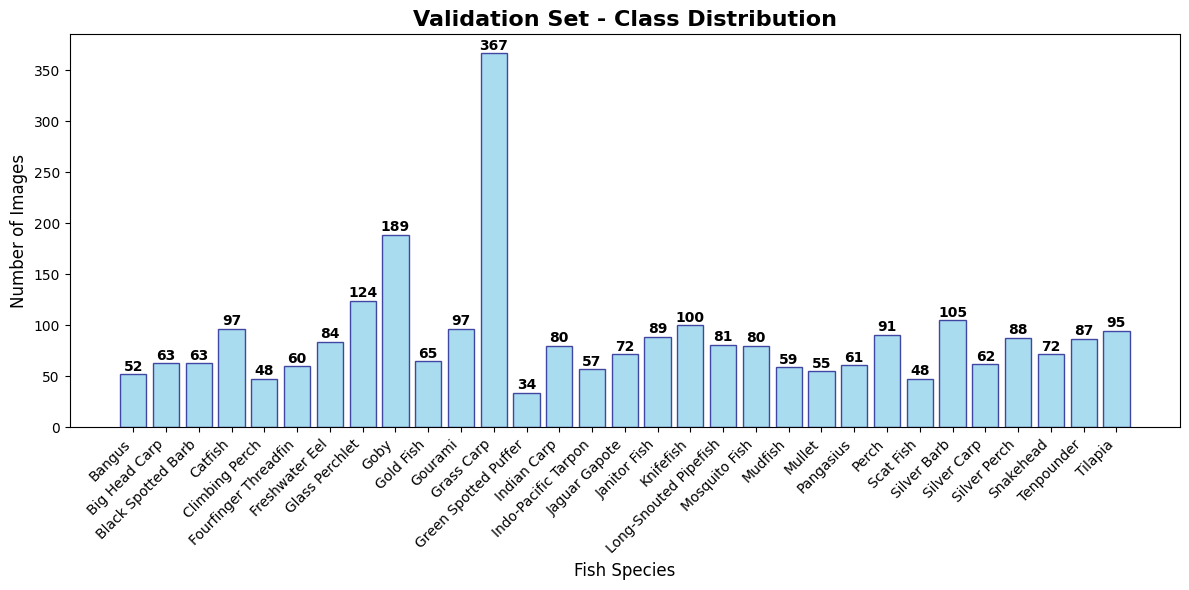

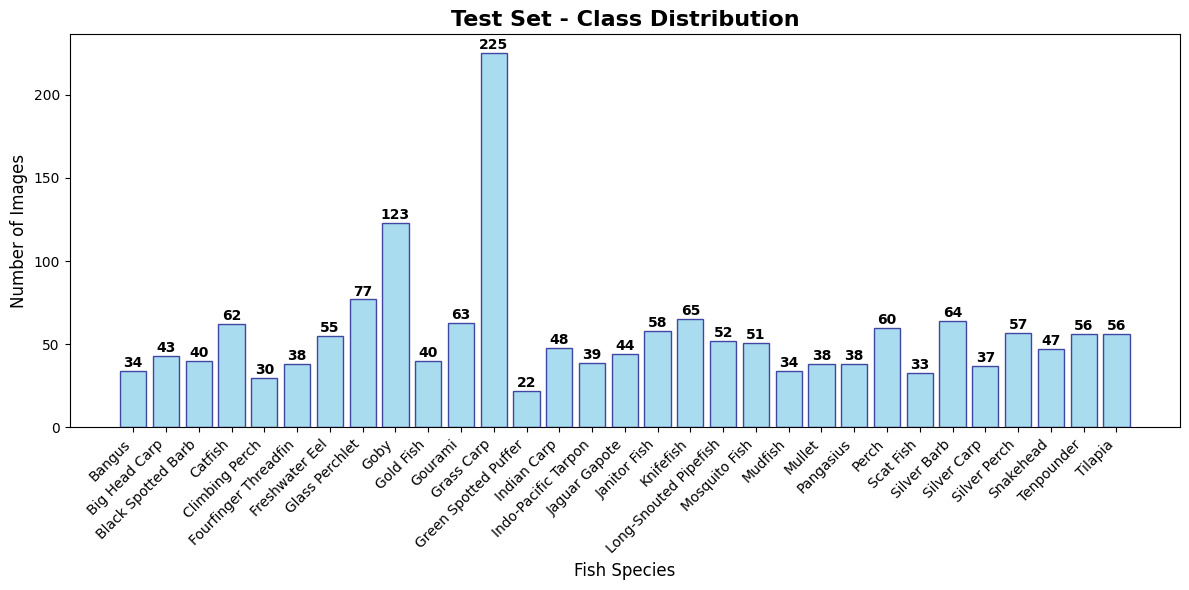

In [4]:
def plot_class_distribution(class_counts, title):
    """
    Plot class distribution

    Args:
        class_counts (dict): Dictionary with class names and counts
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title(f'{title} - Class Distribution', fontsize=16, fontweight='bold')
    plt.xlabel('Fish Species', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plot distributions for each split
if train_counts:
    plot_class_distribution(train_counts, 'Training Set')
if val_counts:
    plot_class_distribution(val_counts, 'Validation Set')
if test_counts:
    plot_class_distribution(test_counts, 'Test Set')

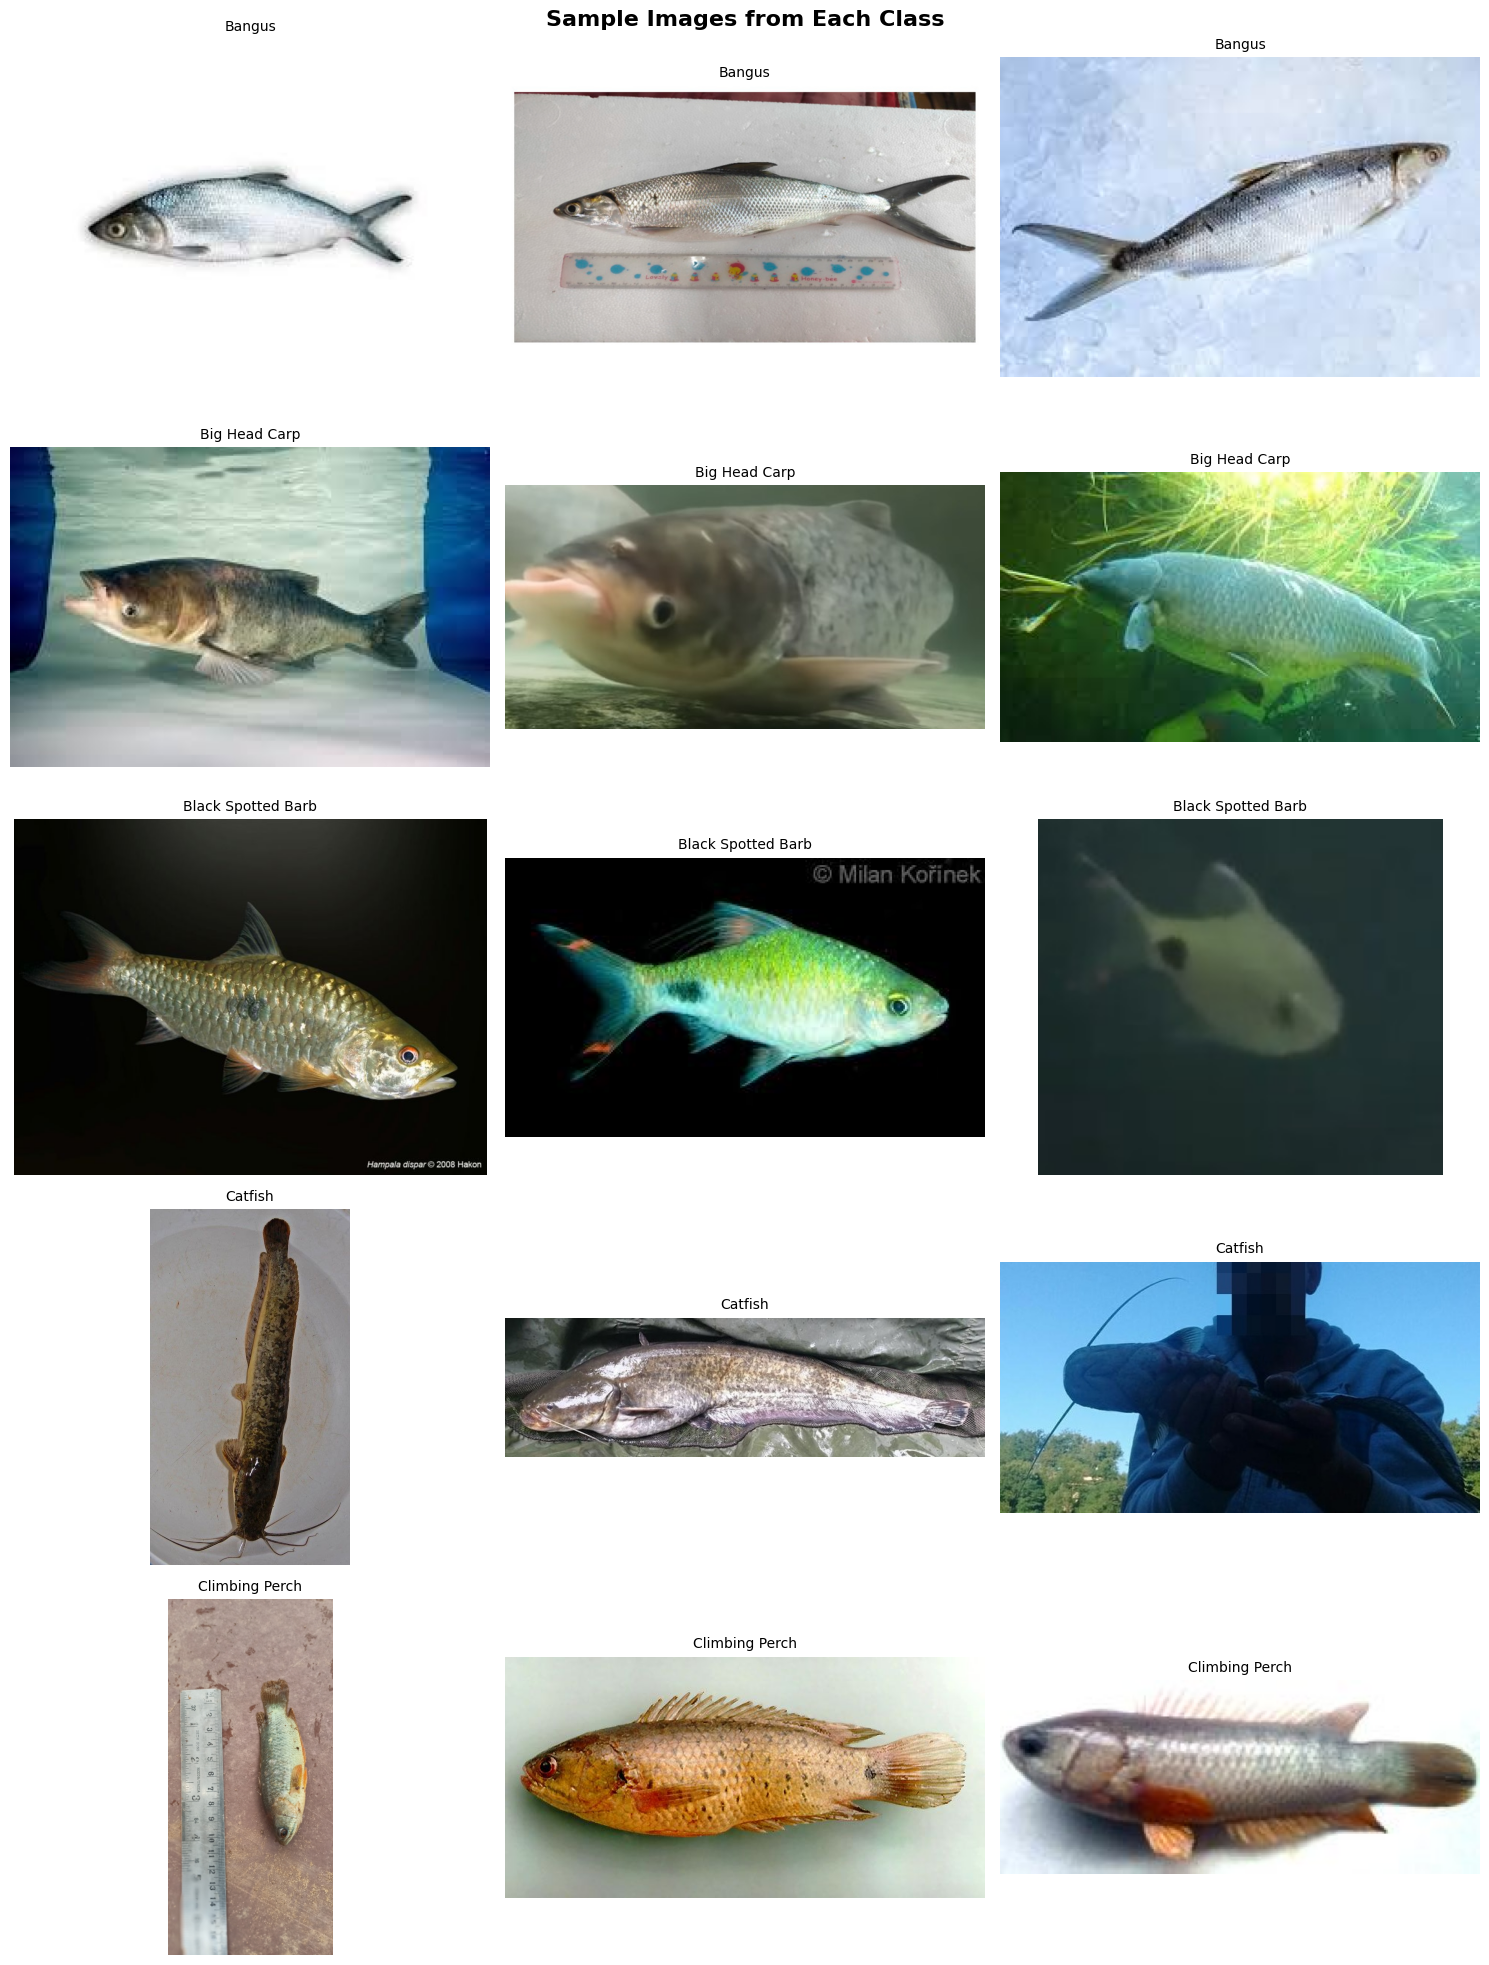

In [5]:
def display_sample_images(dataset_path, classes, num_samples=3):
    """
    Display sample images from each class

    Args:
        dataset_path (str): Path to the dataset
        classes (list): List of class names
        num_samples (int): Number of samples per class
    """
    if not classes:
        print("No classes found!")
        return

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 4*len(classes)))
    fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, '*.jpg')) + \
                     glob(os.path.join(class_path, '*.jpeg')) + \
                     glob(os.path.join(class_path, '*.png'))

        # Select random samples
        sample_images = np.random.choice(image_files, min(num_samples, len(image_files)),
                                       replace=False)

        for j, img_path in enumerate(sample_images):
            img = Image.open(img_path)

            # Handle single row case
            if len(classes) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]

            ax.imshow(img)
            ax.set_title(f'{class_name}', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from training set
if train_classes:
    display_sample_images(TRAIN_PATH, train_classes[:5], 3)  # Show first 5 classes

IMAGE PROPERTIES ANALYSIS
Analyzed 30 images
Image width - Min: 128, Max: 1024, Mean: 492.27
Image height - Min: 93, Max: 1024, Mean: 304.00
File size (bytes) - Min: 2033, Max: 195824, Mean: 34626.93


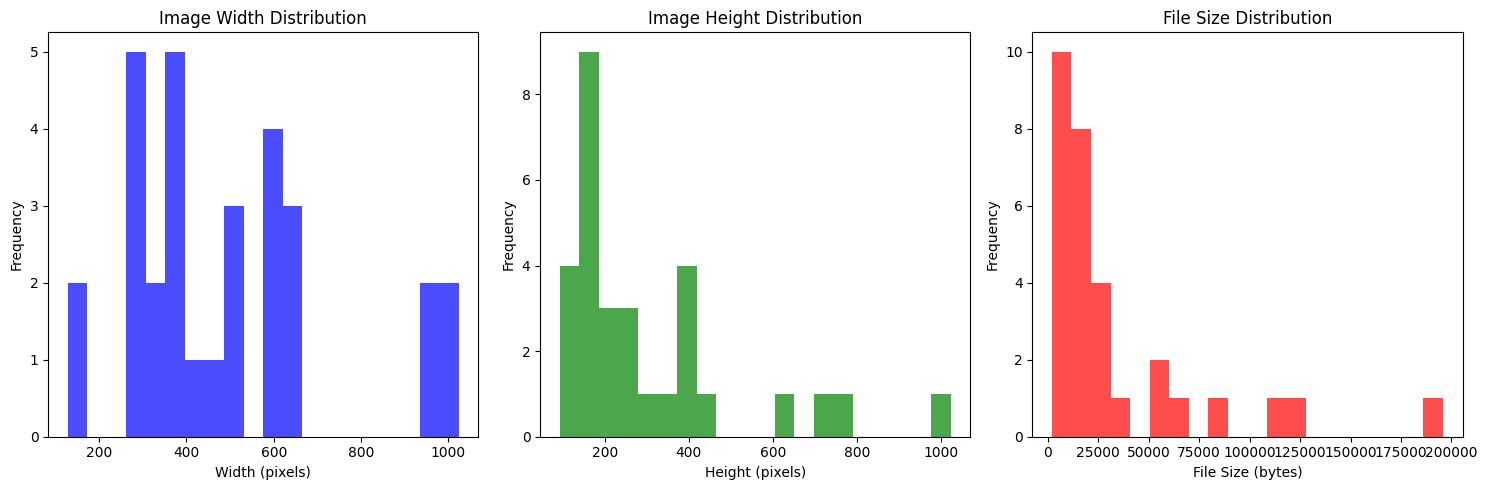

In [6]:
def analyze_image_properties(dataset_path, classes):
    """
    Analyze image properties like dimensions, file sizes, etc.

    Args:
        dataset_path (str): Path to the dataset
        classes (list): List of class names
    """
    print("="*60)
    print("IMAGE PROPERTIES ANALYSIS")
    print("="*60)

    widths = []
    heights = []
    file_sizes = []

    for class_name in classes[:3]:  # Analyze first 3 classes for speed
        class_path = os.path.join(dataset_path, class_name)
        image_files = glob(os.path.join(class_path, '*.jpg')) + \
                     glob(os.path.join(class_path, '*.jpeg')) + \
                     glob(os.path.join(class_path, '*.png'))

        # Sample a few images from each class
        sample_images = np.random.choice(image_files, min(10, len(image_files)),
                                       replace=False)

        for img_path in sample_images:
            try:
                img = Image.open(img_path)
                width, height = img.size
                widths.append(width)
                heights.append(height)
                file_sizes.append(os.path.getsize(img_path))
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Display statistics
    print(f"Analyzed {len(widths)} images")
    print(f"Image width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
    print(f"Image height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")
    print(f"File size (bytes) - Min: {min(file_sizes)}, Max: {max(file_sizes)}, Mean: {np.mean(file_sizes):.2f}")

    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].hist(widths, bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Image Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(heights, bins=20, alpha=0.7, color='green')
    axes[1].set_title('Image Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(file_sizes, bins=20, alpha=0.7, color='red')
    axes[2].set_title('File Size Distribution')
    axes[2].set_xlabel('File Size (bytes)')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return widths, heights, file_sizes

# Analyze image properties
if train_classes:
    widths, heights, file_sizes = analyze_image_properties(TRAIN_PATH, train_classes)

## 4. Feature Engineering and Preprocessing

### Theory: Image Preprocessing for CNN

Image preprocessing is crucial for CNN performance. Key steps include:

1. **Normalization**: Scale pixel values to [0,1] or [-1,1]
   ```
   x_normalized = (x - mean) / std
   ```

2. **Resizing**: Standardize image dimensions
   ```
   x_resized = resize(x, (height, width))
   ```

3. **Data Augmentation**: Increase dataset diversity
   - Rotation, flipping, scaling, cropping
   - Brightness, contrast adjustments

4. **Label Encoding**: Convert categorical labels to numerical format
   - One-hot encoding for multi-class classification
   ```
   y_onehot = to_categorical(y, num_classes)
   ```

In [7]:
# Set image dimensions and parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
CHANNELS = 3

# Get number of classes
if train_classes:
    NUM_CLASSES = len(train_classes)
    print(f"Number of classes: {NUM_CLASSES}")
    print(f"Classes: {train_classes}")
else:
    print("No classes found. Please check dataset structure.")
    NUM_CLASSES = 0

Number of classes: 31
Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [8]:
# Create Label Encoder
label_encoder = LabelEncoder()
if train_classes:
    label_encoder.fit(train_classes)

    # Display label mapping
    print("Label Encoding Mapping:")
    for i, class_name in enumerate(train_classes):
        print(f"  {class_name}: {i}")

    # Create class to index mapping
    class_to_idx = {class_name: i for i, class_name in enumerate(train_classes)}
    idx_to_class = {i: class_name for i, class_name in enumerate(train_classes)}

    print(f"\nClass to index mapping: {class_to_idx}")

Label Encoding Mapping:
  Bangus: 0
  Big Head Carp: 1
  Black Spotted Barb: 2
  Catfish: 3
  Climbing Perch: 4
  Fourfinger Threadfin: 5
  Freshwater Eel: 6
  Glass Perchlet: 7
  Goby: 8
  Gold Fish: 9
  Gourami: 10
  Grass Carp: 11
  Green Spotted Puffer: 12
  Indian Carp: 13
  Indo-Pacific Tarpon: 14
  Jaguar Gapote: 15
  Janitor Fish: 16
  Knifefish: 17
  Long-Snouted Pipefish: 18
  Mosquito Fish: 19
  Mudfish: 20
  Mullet: 21
  Pangasius: 22
  Perch: 23
  Scat Fish: 24
  Silver Barb: 25
  Silver Carp: 26
  Silver Perch: 27
  Snakehead: 28
  Tenpounder: 29
  Tilapia: 30

Class to index mapping: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito 

In [9]:
# TensorFlow/Keras Data Preprocessing
print("Setting up TensorFlow/Keras data preprocessing...")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to [0,1]
    rotation_range=20,                 # Random rotation up to 20 degrees
    width_shift_range=0.2,             # Random horizontal shift
    height_shift_range=0.2,            # Random vertical shift
    shear_range=0.2,                   # Shear transformation
    zoom_range=0.2,                    # Random zoom
    horizontal_flip=True,              # Random horizontal flip
    fill_mode='nearest'                # Fill strategy for new pixels
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
if os.path.exists(TRAIN_PATH):
    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )
    print(f"Training generator created: {train_generator.samples} samples")

if os.path.exists(VAL_PATH):
    val_generator = val_test_datagen.flow_from_directory(
        VAL_PATH,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )
    print(f"Validation generator created: {val_generator.samples} samples")

if os.path.exists(TEST_PATH):
    test_generator = val_test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )
    print(f"Test generator created: {test_generator.samples} samples")

Setting up TensorFlow/Keras data preprocessing...
Found 8801 images belonging to 31 classes.
Training generator created: 8801 samples
Found 2751 images belonging to 31 classes.
Validation generator created: 2751 samples
Found 1760 images belonging to 31 classes.
Test generator created: 1760 samples


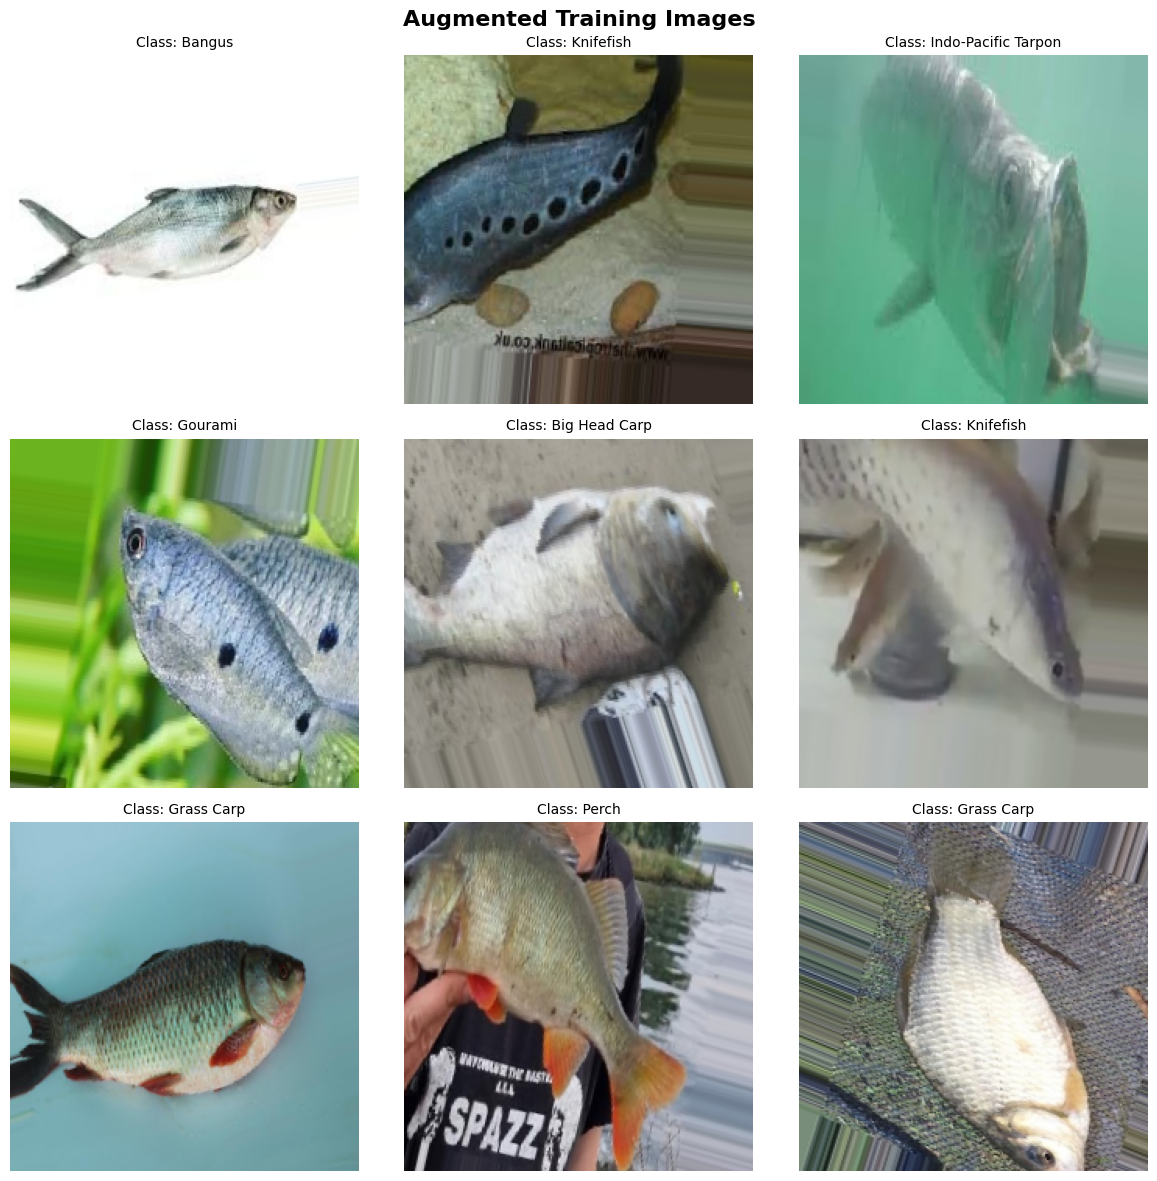

In [10]:
# Display augmented images
def show_augmented_images(generator, num_images=9):
    """
    Display augmented images from the generator

    Args:
        generator: Keras ImageDataGenerator
        num_images (int): Number of images to display
    """
    # Get a batch of images
    batch = next(generator)
    images = batch[0][:num_images]
    labels = batch[1][:num_images]

    # Plot images
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')

    for i, (img, label) in enumerate(zip(images, labels)):
        row = i // 3
        col = i % 3

        axes[row, col].imshow(img)
        # Get class name from one-hot encoded label
        class_idx = np.argmax(label)
        if train_classes:
            class_name = train_classes[class_idx]
            axes[row, col].set_title(f'Class: {class_name}', fontsize=10)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Show augmented images
if 'train_generator' in locals():
    show_augmented_images(train_generator)

## 5. CNN Theory and Mathematical Foundation

### Detailed CNN Architecture Theory

#### 1. Convolutional Layer

The convolutional layer is the core building block of CNNs. It applies a set of learnable filters (kernels) to the input image.

**Mathematical Formula:**
```
Y[i,j] = Σ(m=0 to M-1) Σ(n=0 to N-1) X[i+m, j+n] * W[m,n] + b
```

Where:
- Y[i,j] = Output feature map at position (i,j)
- X = Input image
- W = Filter/Kernel weights
- b = Bias term
- M,N = Filter dimensions

**Parameters:**
- **Filter Size**: Usually 3x3, 5x5, or 7x7
- **Stride**: Step size for moving the filter
- **Padding**: Adding zeros around the input
- **Number of filters**: Determines the depth of output

**Output Size Calculation:**
```
Output_size = (Input_size - Filter_size + 2*Padding
# Convolutional Neural Networks (CNN) Mathematical Foundations

## 1. Convolution Operation

**Mathematical Formula:**
```
Y(i,j) = Σ(m=0 to M-1) Σ(n=0 to N-1) X(i+m, j+n) * K(m,n)
```

Where:
- Y(i,j) = Output feature map at position (i,j)
- X = Input image/feature map
- K = Kernel/Filter
- M, N = Kernel dimensions

**Output Size Calculation:**
```
Output_size = (Input_size - Kernel_size + 2*Padding)/Stride + 1
```

## 2. Activation Functions

**ReLU (Rectified Linear Unit):**
```
f(x) = max(0, x)
```

**Derivative:**
```
f'(x) = 1 if x > 0, else 0
```

**Advantages:**
- Solves vanishing gradient problem
- Computationally efficient
- Sparse activation

## 3. Pooling Layer

**Max Pooling:**
```
P(i,j) = max(X(i*s:i*s+k, j*s:j*s+k))
```

**Average Pooling:**
```
P(i,j) = (1/k²) * Σ(X(i*s:i*s+k, j*s:j*s+k))
```

Where:
- s = stride
- k = pool size

**Purpose:**
- Reduce spatial dimensions
- Translation invariance
- Reduce overfitting

## 4. Fully Connected Layer

**Mathematical Formula:**
```
y = W * x + b
```

Where:
- W = Weight matrix
- x = Input vector (flattened feature maps)
- b = Bias vector
- y = Output vector

## 5. Softmax for Multi-class Classification

**Formula:**
```
σ(z_i) = e^(z_i) / Σ(j=1 to K) e^(z_j)
```

**Properties:**
- Output values sum to 1
- Represents probability distribution
- Used for multi-class classification

## 6. Loss Function (Categorical Cross-Entropy)

**Formula:**
```
L = -Σ(i=1 to N) Σ(j=1 to K) y_ij * log(ŷ_ij)
```

Where:
- N = number of samples
- K = number of classes
- y_ij = true label (one-hot encoded)
- ŷ_ij = predicted probability

## 7. Backpropagation

**Chain Rule:**
```
∂L/∂W = ∂L/∂y * ∂y/∂W
```

**Gradient Descent Update:**
```
W_new = W_old - α * ∂L/∂W
```

Where α is the learning rate.

In [11]:
# PyTorch Data Preprocessing
print("Setting up PyTorch data preprocessing...")

# Define transforms for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet statistics
])

# Define transforms for validation/test (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create PyTorch datasets
if os.path.exists(TRAIN_PATH):
    train_dataset_pytorch = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
    train_loader_pytorch = DataLoader(train_dataset_pytorch, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=2)
    print(f"PyTorch training dataset created: {len(train_dataset_pytorch)} samples")

if os.path.exists(VAL_PATH):
    val_dataset_pytorch = datasets.ImageFolder(VAL_PATH, transform=val_test_transform)
    val_loader_pytorch = DataLoader(val_dataset_pytorch, batch_size=BATCH_SIZE,
                                  shuffle=False, num_workers=2)
    print(f"PyTorch validation dataset created: {len(val_dataset_pytorch)} samples")

if os.path.exists(TEST_PATH):
    test_dataset_pytorch = datasets.ImageFolder(TEST_PATH, transform=val_test_transform)
    test_loader_pytorch = DataLoader(test_dataset_pytorch, batch_size=BATCH_SIZE,
                                   shuffle=False, num_workers=2)
    print(f"PyTorch test dataset created: {len(test_dataset_pytorch)} samples")

# Display class mapping for PyTorch
if 'train_dataset_pytorch' in locals():
    print(f"\nPyTorch class to index mapping: {train_dataset_pytorch.class_to_idx}")

Setting up PyTorch data preprocessing...
PyTorch training dataset created: 8803 samples
PyTorch validation dataset created: 2751 samples
PyTorch test dataset created: 1760 samples

PyTorch class to index mapping: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}


## 6. Model Implementation - TensorFlow/Keras

### Custom CNN Architecture

We'll implement a custom CNN with the following architecture:
1. **Input Layer**: (224, 224, 3)
2. **Conv Block 1**: Conv2D(32) + ReLU + MaxPool2D
3. **Conv Block 2**: Conv2D(64) + ReLU + MaxPool2D
4. **Conv Block 3**: Conv2D(128) + ReLU + MaxPool2D
5. **Conv Block 4**: Conv2D(256) + ReLU + MaxPool2D
6. **Global Average Pooling**
7. **Dense Layer**: 512 units + ReLU + Dropout
8. **Output Layer**: NUM_CLASSES units + Softmax

In [12]:
def create_cnn_model_tensorflow(input_shape, num_classes):
    """
    Create a custom CNN model using TensorFlow/Keras

    Args:
        input_shape (tuple): Input image shape (height, width, channels)
        num_classes (int): Number of output classes

    Returns:
        tensorflow.keras.Model: Compiled CNN model
    """
    model = keras.Sequential([
        # Input layer
        keras.Input(shape=input_shape),

        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Global Average Pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
if NUM_CLASSES > 0:
    model_tf = create_cnn_model_tensorflow((IMG_HEIGHT, IMG_WIDTH, CHANNELS), NUM_CLASSES)

    # Display model architecture
    print("TensorFlow/Keras Model Architecture:")
    model_tf.summary()

    # Compile the model
    model_tf.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    print("\nModel compiled successfully!")
else:
    print("Cannot create model: No classes found in dataset.")

TensorFlow/Keras Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,871 (2.06 MB)

 Trainable params: 537,887 (2.05 MB)

 Non-trainable params: 1,984 (7.75 KB)


Model compiled successfully!


In [13]:
# Define callbacks for training
callbacks_tf = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_tf.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks defined:")
print("- EarlyStopping: Stops training if val_loss doesn't improve for 10 epochs")
print("- ReduceLROnPlateau: Reduces learning rate if val_loss doesn't improve for 5 epochs")
print("- ModelCheckpoint: Saves best model based on val_accuracy")

Callbacks defined:
- EarlyStopping: Stops training if val_loss doesn't improve for 10 epochs
- ReduceLROnPlateau: Reduces learning rate if val_loss doesn't improve for 5 epochs
- ModelCheckpoint: Saves best model based on val_accuracy


In [14]:
# Train the TensorFlow model
if 'model_tf' in locals() and 'train_generator' in locals() and 'val_generator' in locals():
    print("Starting TensorFlow model training...")

    EPOCHS = 50

    # Calculate steps per epoch
    steps_per_epoch = train_generator.samples // BATCH_SIZE
    validation_steps = val_generator.samples // BATCH_SIZE

    print(f"Training for {EPOCHS} epochs")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Train the model
    history_tf = model_tf.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks_tf,
        verbose=1
    )

    print("\nTensorFlow model training completed!")
else:
    print("Cannot train model: Missing model or data generators.")

Starting TensorFlow model training...
Training for 50 epochs
Steps per epoch: 275
Validation steps: 85
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.1221 - loss: 3.9403 - precision: 0.1951 - recall: 0.0382
Epoch 1: val_accuracy improved from -inf to 0.03456, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 197s 656ms/step - accuracy: 0.1222 - loss: 3.9393 - precision: 0.1953 - recall: 0.0383 - val_accuracy: 0.0346 - val_loss: 5.8197 - val_precision: 0.0384 - val_recall: 0.0298 - learning_rate: 0.0010
Epoch 2/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.1250 - loss: 3.3414 - precision: 0.3333 - recall: 0.0938
Epoch 2: val_accuracy improved from 0.03456 to 0.03640, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1250 - loss: 3.3414 - precision: 0.3333 - recall: 0.0938 - val_accuracy: 0.0364 - val_loss: 5.8839 - val_precision: 0.0393 - val_recall: 0.0309 - learning_rate: 0.0010
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.2176 - loss: 3.1393 - precision: 0.4300 - recall: 0.0940
Epoch 3: val_accuracy improved from 0.03640 to 0.21765, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 734ms/step - accuracy: 0.2176 - loss: 3.1392 - precision: 0.4301 - recall: 0.0940 - val_accuracy: 0.2176 - val_loss: 3.4682 - val_precision: 0.3901 - val_recall: 0.1559 - learning_rate: 0.0010
Epoch 4/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.2500 - loss: 2.9366 - precision: 0.4286 - recall: 0.0938
Epoch 4: val_accuracy improved from 0.21765 to 0.22537, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.2500 - loss: 2.9366 - precision: 0.4286 - recall: 0.0938 - val_accuracy: 0.2254 - val_loss: 3.1760 - val_precision: 0.4498 - val_recall: 0.1301 - learning_rate: 0.0010
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.2726 - loss: 2.7577 - precision: 0.5794 - recall: 0.1425
Epoch 5: val_accuracy did not improve from 0.22537
275/275 ━━━━━━━━━━━━━━━━━━━━ 262s 780ms/step - accuracy: 0.2727 - loss: 2.7576 - precision: 0.5795 - recall: 0.1425 - val_accuracy: 0.2228 - val_loss: 3.1091 - val_precision: 0.4118 - val_recall: 0.1537 - learning_rate: 0.0010
Epoch 6/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.3125 - loss: 2.0635 - precision: 0.4286 - recall: 0.1875
Epoch 6: val_accuracy improved from 0.22537 to 0.23015, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3125 - loss: 2.0635 - precision: 0.4286 - recall: 0.1875 - val_accuracy: 0.2301 - val_loss: 3.1328 - val_precision: 0.4007 - val_recall: 0.1603 - learning_rate: 0.0010
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.3027 - loss: 2.5557 - precision: 0.6025 - recall: 0.1571
Epoch 7: val_accuracy did not improve from 0.23015
275/275 ━━━━━━━━━━━━━━━━━━━━ 196s 585ms/step - accuracy: 0.3028 - loss: 2.5553 - precision: 0.6026 - recall: 0.1571 - val_accuracy: 0.0960 - val_loss: 6.2950 - val_precision: 0.1371 - val_recall: 0.0485 - learning_rate: 0.0010
Epoch 8/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.2188 - loss: 3.0644 - precision: 0.5714 - recall: 0.1250
Epoch 8: val_accuracy did not improve from 0.23015
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.2188 - loss: 3.0644 - precision: 0.5714 - recall: 0.1250 - val_accuracy: 0.1044 - val_loss: 5.7911 - val_precision: 0.1529 - val_recall: 0.

275/275 ━━━━━━━━━━━━━━━━━━━━ 201s 659ms/step - accuracy: 0.3641 - loss: 2.2696 - precision: 0.6899 - recall: 0.2050 - val_accuracy: 0.3004 - val_loss: 2.6735 - val_precision: 0.4722 - val_recall: 0.2092 - learning_rate: 0.0010
Epoch 10/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.3438 - loss: 2.3400 - precision: 0.7778 - recall: 0.2188
Epoch 10: val_accuracy did not improve from 0.30037
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.3438 - loss: 2.3400 - precision: 0.7778 - recall: 0.2188 - val_accuracy: 0.2923 - val_loss: 2.6945 - val_precision: 0.4640 - val_recall: 0.2015 - learning_rate: 0.0010
Epoch 11/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.4197 - loss: 2.0812 - precision: 0.7224 - recall: 0.2425
Epoch 11: val_accuracy improved from 0.30037 to 0.45037, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 162s 587ms/step - accuracy: 0.4197 - loss: 2.0811 - precision: 0.7224 - recall: 0.2425 - val_accuracy: 0.4504 - val_loss: 1.9338 - val_precision: 0.7547 - val_recall: 0.2805 - learning_rate: 0.0010
Epoch 12/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5000 - loss: 1.8728 - precision: 0.7692 - recall: 0.3125
Epoch 12: val_accuracy did not improve from 0.45037
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5000 - loss: 1.8728 - precision: 0.7692 - recall: 0.3125 - val_accuracy: 0.4423 - val_loss: 1.9641 - val_precision: 0.7473 - val_recall: 0.2794 - learning_rate: 0.0010
Epoch 13/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.4429 - loss: 1.9547 - precision: 0.7281 - recall: 0.2760
Epoch 13: val_accuracy did not improve from 0.45037
275/275 ━━━━━━━━━━━━━━━━━━━━ 160s 581ms/step - accuracy: 0.4429 - loss: 1.9547 - precision: 0.7281 - recall: 0.2761 - val_accuracy: 0.4382 - val_loss: 1.9592 - val_precision: 0.6661 - val_reca

275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 733ms/step - accuracy: 0.5574 - loss: 1.5157 - precision: 0.8192 - recall: 0.3832 - val_accuracy: 0.5607 - val_loss: 1.5716 - val_precision: 0.7627 - val_recall: 0.4206 - learning_rate: 2.0000e-04
Epoch 20/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.4688 - loss: 1.6687 - precision: 0.6667 - recall: 0.3125
Epoch 20: val_accuracy improved from 0.56066 to 0.56581, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.4688 - loss: 1.6687 - precision: 0.6667 - recall: 0.3125 - val_accuracy: 0.5658 - val_loss: 1.5329 - val_precision: 0.7706 - val_recall: 0.4261 - learning_rate: 2.0000e-04
Epoch 21/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.5573 - loss: 1.5082 - precision: 0.7980 - recall: 0.3813
Epoch 21: val_accuracy did not improve from 0.56581
275/275 ━━━━━━━━━━━━━━━━━━━━ 262s 780ms/step - accuracy: 0.5573 - loss: 1.5082 - precision: 0.7980 - recall: 0.3814 - val_accuracy: 0.5643 - val_loss: 1.6338 - val_precision: 0.7171 - val_recall: 0.4268 - learning_rate: 2.0000e-04
Epoch 22/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.4375 - loss: 2.0049 - precision: 0.7500 - recall: 0.2812
Epoch 22: val_accuracy did not improve from 0.56581
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.4375 - loss: 2.0049 - precision: 0.7500 - recall: 0.2812 - val_accuracy: 0.5430 - val_loss: 1.7378 - val_precision: 0.6991 - va

275/275 ━━━━━━━━━━━━━━━━━━━━ 202s 662ms/step - accuracy: 0.5918 - loss: 1.3701 - precision: 0.8208 - recall: 0.4233 - val_accuracy: 0.5827 - val_loss: 1.4878 - val_precision: 0.7442 - val_recall: 0.4599 - learning_rate: 2.0000e-04
Epoch 26/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.5938 - loss: 1.3387 - precision: 0.8235 - recall: 0.4375
Epoch 26: val_accuracy improved from 0.58272 to 0.58346, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.5938 - loss: 1.3387 - precision: 0.8235 - recall: 0.4375 - val_accuracy: 0.5835 - val_loss: 1.4908 - val_precision: 0.7451 - val_recall: 0.4588 - learning_rate: 2.0000e-04
Epoch 27/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.5945 - loss: 1.3769 - precision: 0.8155 - recall: 0.4409
Epoch 27: val_accuracy improved from 0.58346 to 0.60625, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 262s 739ms/step - accuracy: 0.5945 - loss: 1.3768 - precision: 0.8156 - recall: 0.4409 - val_accuracy: 0.6062 - val_loss: 1.4743 - val_precision: 0.7504 - val_recall: 0.4886 - learning_rate: 2.0000e-04
Epoch 28/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.5625 - loss: 1.3263 - precision: 0.8421 - recall: 0.5000
Epoch 28: val_accuracy improved from 0.60625 to 0.60882, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5625 - loss: 1.3263 - precision: 0.8421 - recall: 0.5000 - val_accuracy: 0.6088 - val_loss: 1.4755 - val_precision: 0.7520 - val_recall: 0.4926 - learning_rate: 2.0000e-04
Epoch 29/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6141 - loss: 1.3174 - precision: 0.8345 - recall: 0.4568
Epoch 29: val_accuracy did not improve from 0.60882
275/275 ━━━━━━━━━━━━━━━━━━━━ 208s 586ms/step - accuracy: 0.6141 - loss: 1.3174 - precision: 0.8345 - recall: 0.4568 - val_accuracy: 0.5930 - val_loss: 1.4828 - val_precision: 0.7528 - val_recall: 0.4735 - learning_rate: 2.0000e-04
Epoch 30/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.5000 - loss: 1.5437 - precision: 0.7143 - recall: 0.4688
Epoch 30: val_accuracy did not improve from 0.60882
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.5000 - loss: 1.5437 - precision: 0.7143 - recall: 0.4688 - val_accuracy: 0.5967 - val_loss: 1.4644 - val_precision: 0.7583 - va

275/275 ━━━━━━━━━━━━━━━━━━━━ 182s 589ms/step - accuracy: 0.6219 - loss: 1.2821 - precision: 0.8315 - recall: 0.4615 - val_accuracy: 0.6371 - val_loss: 1.3452 - val_precision: 0.7793 - val_recall: 0.5324 - learning_rate: 2.0000e-04
Epoch 32/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7188 - loss: 0.9213 - precision: 0.8947 - recall: 0.5312
Epoch 32: val_accuracy did not improve from 0.63713
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.7188 - loss: 0.9213 - precision: 0.8947 - recall: 0.5312 - val_accuracy: 0.6250 - val_loss: 1.4106 - val_precision: 0.7569 - val_recall: 0.5210 - learning_rate: 2.0000e-04
Epoch 33/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6243 - loss: 1.2616 - precision: 0.8443 - recall: 0.4742
Epoch 33: val_accuracy improved from 0.63713 to 0.67243, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 189s 588ms/step - accuracy: 0.6243 - loss: 1.2616 - precision: 0.8442 - recall: 0.4742 - val_accuracy: 0.6724 - val_loss: 1.1649 - val_precision: 0.8053 - val_recall: 0.5596 - learning_rate: 2.0000e-04
Epoch 34/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.5938 - loss: 1.5656 - precision: 0.7500 - recall: 0.4688
Epoch 34: val_accuracy improved from 0.67243 to 0.67316, saving model to best_model_tf.h5


275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5938 - loss: 1.5656 - precision: 0.7500 - recall: 0.4688 - val_accuracy: 0.6732 - val_loss: 1.1666 - val_precision: 0.8089 - val_recall: 0.5618 - learning_rate: 2.0000e-04
Epoch 35/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6523 - loss: 1.2063 - precision: 0.8518 - recall: 0.4993
Epoch 35: val_accuracy did not improve from 0.67316
275/275 ━━━━━━━━━━━━━━━━━━━━ 189s 590ms/step - accuracy: 0.6522 - loss: 1.2063 - precision: 0.8518 - recall: 0.4993 - val_accuracy: 0.6279 - val_loss: 1.5494 - val_precision: 0.7439 - val_recall: 0.5265 - learning_rate: 2.0000e-04
Epoch 36/50
  1/275 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.5625 - loss: 1.1583 - precision: 0.6667 - recall: 0.3750
Epoch 36: val_accuracy did not improve from 0.67316
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5625 - loss: 1.1583 - precision: 0.6667 - recall: 0.3750 - val_accuracy: 0.6224 - val_loss: 1.6051 - val_precision: 0.7412 - va

## 7. Model Implementation - PyTorch

### Custom CNN Class in PyTorch

We'll implement the same architecture using PyTorch's nn.Module for comparison.

In [15]:
class CNN_PyTorch(nn.Module):
    """
    Custom CNN implementation using PyTorch

    Architecture:
    - 4 Convolutional blocks (Conv2d + BatchNorm + ReLU + MaxPool + Dropout)
    - Global Average Pooling
    - Fully Connected layers with Dropout
    - Output layer with Softmax
    """

    def __init__(self, num_classes):
        super(CNN_PyTorch, self).__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 224, 224)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        # Apply convolutional blocks
        x = self.conv_block1(x)  # (batch_size, 32, 112, 112)
        x = self.conv_block2(x)  # (batch_size, 64, 56, 56)
        x = self.conv_block3(x)  # (batch_size, 128, 28, 28)
        x = self.conv_block4(x)  # (batch_size, 256, 14, 14)

        # Global average pooling
        x = self.global_avg_pool(x)  # (batch_size, 256, 1, 1)

        # Classification
        x = self.classifier(x)  # (batch_size, num_classes)

        return x

# Create PyTorch model
if NUM_CLASSES > 0:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create model
    model_pytorch = CNN_PyTorch(NUM_CLASSES).to(device)

    # Display model architecture
    print("\nPyTorch Model Architecture:")
    print(model_pytorch)

    # Count parameters
    total_params = sum(p.numel() for p in model_pytorch.parameters())
    trainable_params = sum(p.numel() for p in model_pytorch.parameters() if p.requires_grad)

    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2,
                                                   patience=5, verbose=True)

    print("\nPyTorch model created and configured successfully!")
else:
    print("Cannot create PyTorch model: No classes found in dataset.")

Using device: cuda

PyTorch Model Architecture:
CNN_PyTorch(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPoo

In [16]:
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer,
                       scheduler, device, epochs=50):
    """
    Train PyTorch model with detailed logging and validation

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device (CPU/GPU)
        epochs: Number of training epochs

    Returns:
        dict: Training history
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 10

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}: Loss: {loss.item():.4f}')

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total

        # Update learning rate
        scheduler.step(avg_val_loss)

        # Save metrics
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        # Print epoch results
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Early stopping and model saving
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model_pytorch.pth')
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model
    model.load_state_dict(torch.load('best_model_pytorch.pth'))
    print(f'\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%')

    return history

# Train the PyTorch model
if ('model_pytorch' in locals() and 'train_loader_pytorch' in locals()
    and 'val_loader_pytorch' in locals()):

    print("Starting PyTorch model training...")
    history_pytorch = train_pytorch_model(
        model_pytorch, train_loader_pytorch, val_loader_pytorch,
        criterion, optimizer, scheduler, device, epochs=50
    )
    print("\nPyTorch model training completed!")
else:
    print("Cannot train PyTorch model: Missing model or data loaders.")

Starting PyTorch model training...

Epoch 1/50
--------------------------------------------------
Batch 0/276: Loss: 3.5631
Batch 10/276: Loss: 3.3723
Batch 20/276: Loss: 3.1659
Batch 30/276: Loss: 3.2801
Batch 40/276: Loss: 3.3915
Batch 50/276: Loss: 3.5165
Batch 60/276: Loss: 3.3292
Batch 70/276: Loss: 3.1144
Batch 80/276: Loss: 3.1350
Batch 90/276: Loss: 3.6437
Batch 100/276: Loss: 3.3091
Batch 110/276: Loss: 2.9841
Batch 120/276: Loss: 3.1455
Batch 130/276: Loss: 3.1972
Batch 140/276: Loss: 3.0441
Batch 150/276: Loss: 3.4462
Batch 160/276: Loss: 3.2969
Batch 170/276: Loss: 3.3380
Batch 180/276: Loss: 3.2165
Batch 190/276: Loss: 3.1686
Batch 200/276: Loss: 2.8884
Batch 210/276: Loss: 3.5437
Batch 220/276: Loss: 3.0340
Batch 230/276: Loss: 3.0060
Batch 240/276: Loss: 3.2099
Batch 250/276: Loss: 3.1617
Batch 260/276: Loss: 3.3730
Batch 270/276: Loss: 2.9539
Train Loss: 3.2131, Train Acc: 14.78%
Val Loss: 2.8673, Val Acc: 20.68%
New best model saved with validation accuracy: 20.68%

Ep

KeyboardInterrupt: 

## 8. Model Evaluation and Comparison

### Evaluation Metrics Theory

#### 1. Accuracy
```
Accuracy = (TP + TN) / (TP + TN + FP + FN)
```

#### 2. Precision
```
Precision = TP / (TP + FP)
```

#### 3. Recall (Sensitivity)
```
Recall = TP / (TP + FN)
```

#### 4. F1-Score
```
F1 = 2 * (Precision * Recall) / (Precision + Recall)
```

#### 5. AUC-ROC
Area Under the Receiver Operating Characteristic curve
- Measures the ability to distinguish between classes
- Values range from 0 to 1 (higher is better)

Where:
- TP = True Positives
- TN = True Negatives
- FP = False Positives
- FN = False Negatives

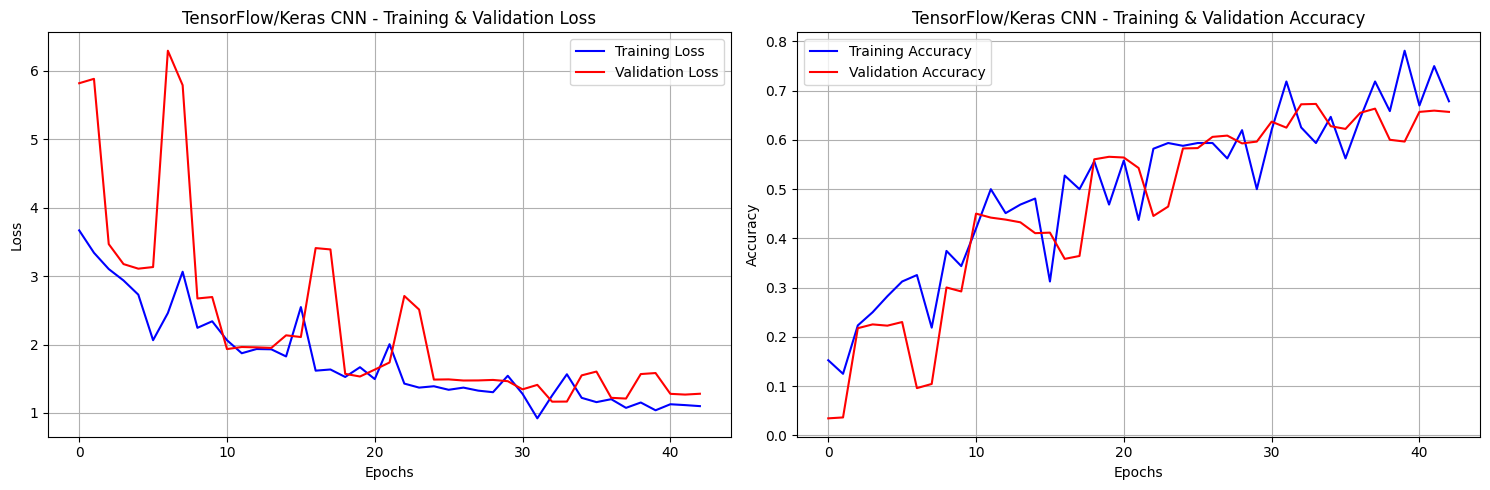

In [17]:
def plot_training_history(history, title):
    """
    Plot training history (loss and accuracy)
    Args:
        history: Training history dictionary or object
        title (str): Title for the plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    if hasattr(history, 'history'):  # TensorFlow history
        axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
        axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    else:  # PyTorch history
        axes[0].plot(history['train_loss'], label='Training Loss', color='blue')
        axes[0].plot(history['val_loss'], label='Validation Loss', color='red')
        axes[1].plot(history['train_acc'], label='Training Accuracy', color='blue')
        axes[1].plot(history['val_acc'], label='Validation Accuracy', color='red')

    axes[0].set_title(f'{title} - Training & Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title(f'{title} - Training & Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot training histories
if 'history_tf' in locals():
    plot_training_history(history_tf, 'TensorFlow/Keras CNN')

if 'history_pytorch' in locals():
    plot_training_history(history_pytorch, 'PyTorch CNN')

Evaluating TensorFlow Model...
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step
Accuracy: 0.6881
Precision: 0.7140
Recall: 0.6881
F1-Score: 0.6854

Detailed Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.43      0.62      0.51        34
        Big Head Carp       0.68      0.40      0.50        43
   Black Spotted Barb       0.74      0.50      0.60        40
              Catfish       0.60      0.66      0.63        62
       Climbing Perch       0.31      0.13      0.19        30
 Fourfinger Threadfin       0.49      0.71      0.58        38
       Freshwater Eel       0.51      0.65      0.57        55
       Glass Perchlet       0.77      0.75      0.76        77
                 Goby       0.67      0.72      0.69       124
            Gold Fish       1.00      0.90      0.95        41
              Gourami       0.91      0.79      0.85        63
           Grass Carp       0.77      0.97      0.86       238
 Green 

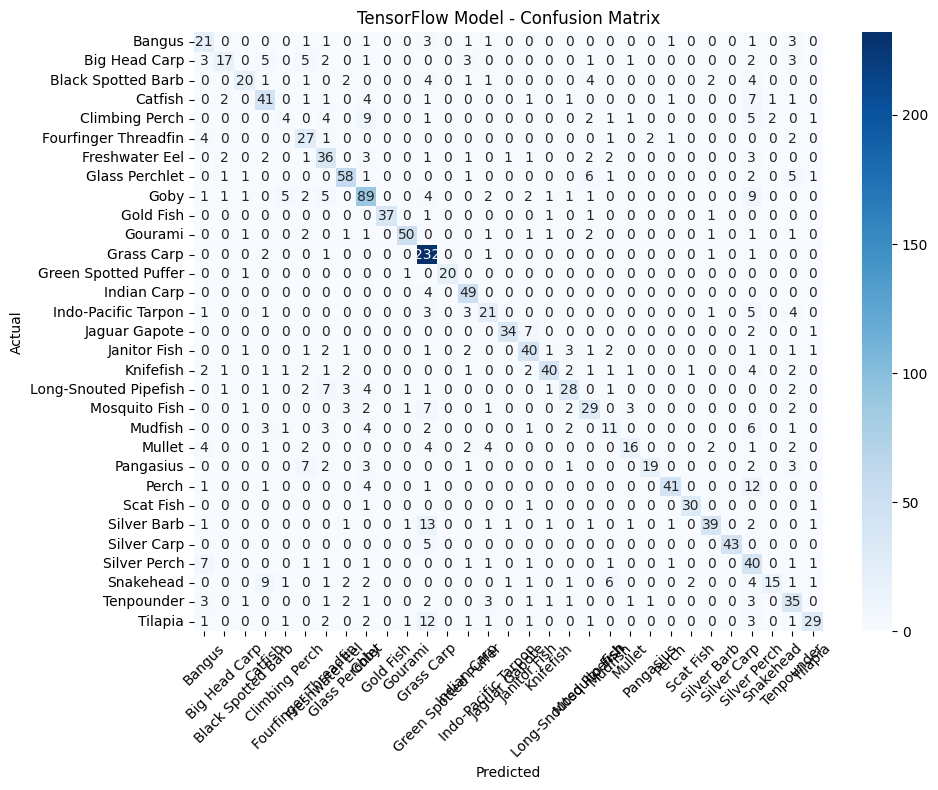

In [18]:
def evaluate_tensorflow_model(model, test_generator, class_names):
    """
    Evaluate TensorFlow model and generate comprehensive metrics

    Args:
        model: Trained TensorFlow model
        test_generator: Test data generator
        class_names: List of class names

    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    print("Evaluating TensorFlow Model...")
    print("="*50)

    # Reset generator
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('TensorFlow Model - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes
    }

# Evaluate TensorFlow model
if ('model_tf' in locals() and 'test_generator' in locals() and train_classes):
    tf_results = evaluate_tensorflow_model(model_tf, test_generator, train_classes)
else:
    print("Cannot evaluate TensorFlow model: Missing model or test data.")

Evaluating PyTorch Model...
Accuracy: 0.3869
Precision: 0.4100
Recall: 0.3869
F1-Score: 0.3333

Detailed Classification Report:
                       precision    recall  f1-score   support

               Bangus       1.00      0.03      0.06        34
        Big Head Carp       0.67      0.05      0.09        43
   Black Spotted Barb       0.19      0.12      0.15        40
              Catfish       0.30      0.44      0.36        62
       Climbing Perch       0.00      0.00      0.00        30
 Fourfinger Threadfin       0.12      0.08      0.10        38
       Freshwater Eel       0.67      0.11      0.19        55
       Glass Perchlet       0.28      0.51      0.36        77
                 Goby       0.27      0.69      0.39       124
            Gold Fish       0.63      0.93      0.75        41
              Gourami       0.39      0.51      0.44        63
           Grass Carp       0.58      0.92      0.71       238
 Green Spotted Puffer       0.50      0.09      0.15

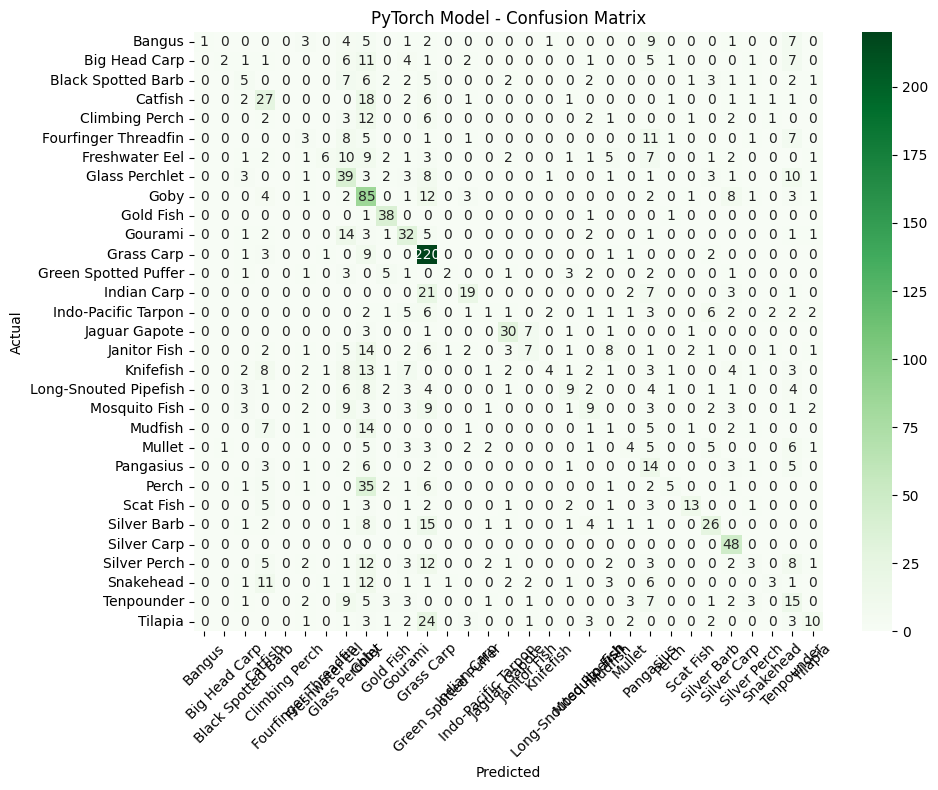

In [19]:
def evaluate_pytorch_model(model, test_loader, class_names, device):
    """
    Evaluate PyTorch model and generate comprehensive metrics

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        class_names: List of class names
        device: Device (CPU/GPU)

    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    print("Evaluating PyTorch Model...")
    print("="*50)

    model.eval()
    all_predictions = []
    all_probabilities = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Convert to numpy arrays
    predicted_classes = np.array(all_predictions)
    true_classes = np.array(all_targets)
    probabilities = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('PyTorch Model - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'probabilities': probabilities,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes
    }

# Evaluate PyTorch model
if ('model_pytorch' in locals() and 'test_loader_pytorch' in locals() and train_classes):
    pytorch_results = evaluate_pytorch_model(model_pytorch, test_loader_pytorch,
                                            train_classes, device)
else:
    print("Cannot evaluate PyTorch model: Missing model or test data.")

MODEL COMPARISON
Performance Comparison:
      Metric  TensorFlow  PyTorch  Difference
0   Accuracy      0.6881   0.3869     -0.3011
1  Precision      0.7140   0.4100     -0.3040
2     Recall      0.6881   0.3869     -0.3011
3   F1-Score      0.6854   0.3333     -0.3520


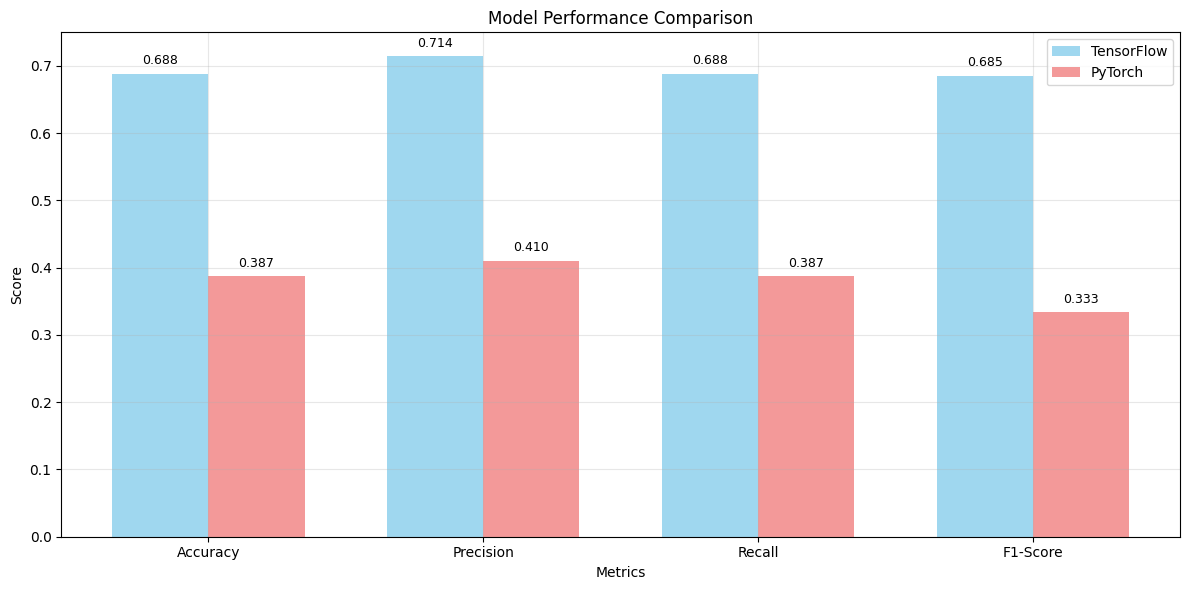


🏆 TensorFlow model performs better overall!


In [20]:
# Compare model performances
def compare_models(tf_results=None, pytorch_results=None):
    """
    Compare performance of TensorFlow and PyTorch models

    Args:
        tf_results: TensorFlow model evaluation results
        pytorch_results: PyTorch model evaluation results
    """
    print("MODEL COMPARISON")
    print("="*60)

    if tf_results and pytorch_results:
        # Create comparison dataframe
        comparison_data = {
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
            'TensorFlow': [
                tf_results['accuracy'],
                tf_results['precision'],
                tf_results['recall'],
                tf_results['f1_score']
            ],
            'PyTorch': [
                pytorch_results['accuracy'],
                pytorch_results['precision'],
                pytorch_results['recall'],
                pytorch_results['f1_score']
            ]
        }

        df_comparison = pd.DataFrame(comparison_data)
        df_comparison['Difference'] = df_comparison['PyTorch'] - df_comparison['TensorFlow']

        print("Performance Comparison:")
        print(df_comparison.round(4))

        # Visualize comparison
        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(comparison_data['Metric']))
        width = 0.35

        bars1 = ax.bar(x - width/2, comparison_data['TensorFlow'], width,
                      label='TensorFlow', color='skyblue', alpha=0.8)
        bars2 = ax.bar(x + width/2, comparison_data['PyTorch'], width,
                      label='PyTorch', color='lightcoral', alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(comparison_data['Metric'])
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Determine best model
        if df_comparison['TensorFlow'].mean() > df_comparison['PyTorch'].mean():
            print("\n🏆 TensorFlow model performs better overall!")
        elif df_comparison['PyTorch'].mean() > df_comparison['TensorFlow'].mean():
            print("\n🏆 PyTorch model performs better overall!")
        else:
            print("\n🤝 Both models perform equally well!")

    elif tf_results:
        print("Only TensorFlow results available:")
        print(f"Accuracy: {tf_results['accuracy']:.4f}")
        print(f"F1-Score: {tf_results['f1_score']:.4f}")

    elif pytorch_results:
        print("Only PyTorch results available:")
        print(f"Accuracy: {pytorch_results['accuracy']:.4f}")
        print(f"F1-Score: {pytorch_results['f1_score']:.4f}")

    else:
        print("No model results available for comparison.")

# Compare models
tf_res = tf_results if 'tf_results' in locals() else None
pytorch_res = pytorch_results if 'pytorch_results' in locals() else None
compare_models(tf_res, pytorch_res)

## 9. Results Interpretation

### Model Performance Analysis

#### Evaluation Metrics Interpretation:

1. **Accuracy**: Overall correctness of the model
   - Good for balanced datasets
   - Can be misleading with imbalanced classes

2. **Precision**: How many selected items are relevant
   - Important when false positives are costly
   - Formula: TP / (TP + FP)

3. **Recall**: How many relevant items are selected
   - Important when false negatives are costly
   - Formula: TP / (TP + FN)

4. **F1-Score**: Harmonic mean of precision and recall
   - Balanced measure for imbalanced datasets
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)

#### Which Metric is Best?

The choice of metric depends on the problem:

- **Balanced Dataset**: Accuracy is sufficient
- **Imbalanced Dataset**: F1-Score or AUC-ROC
- **High Cost of False Positives**: Precision
- **High Cost of False Negatives**: Recall
- **Medical/Safety Applications**: Recall (to catch all positive cases)
- **Spam Detection**: Precision (to avoid blocking legitimate emails)

For fish classification, **F1-Score** is typically the best overall metric as it balances both precision and recall.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


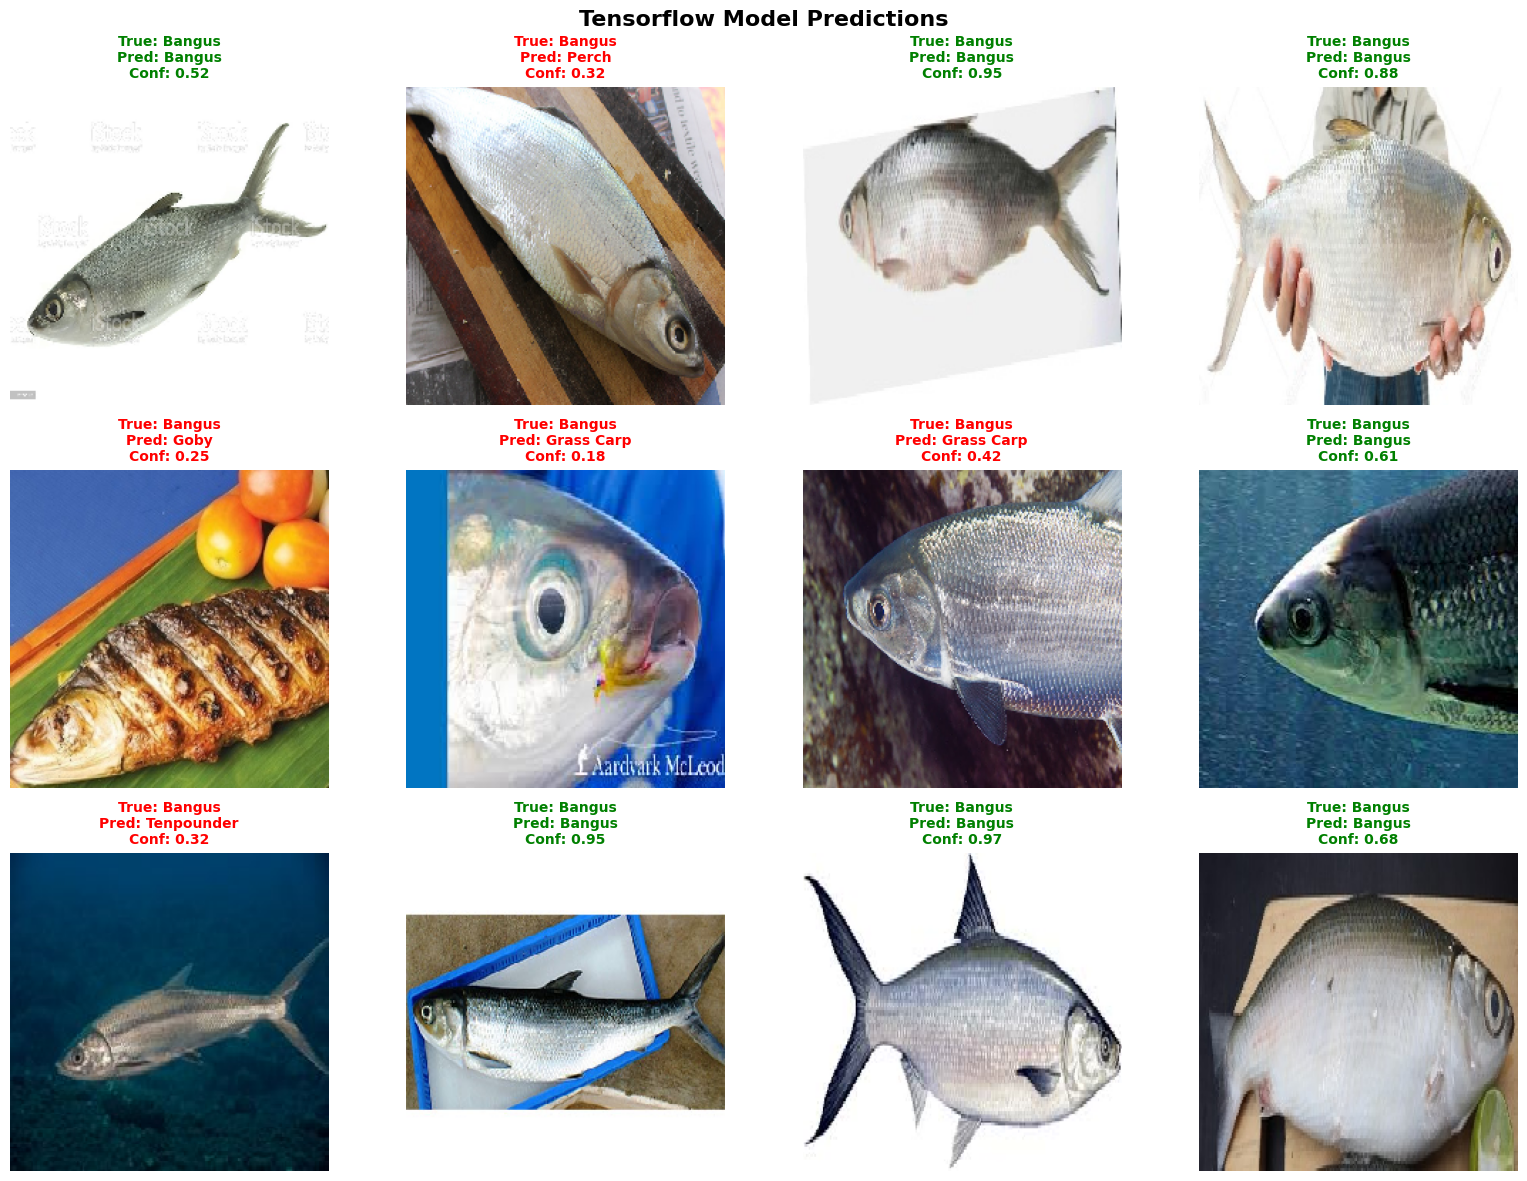

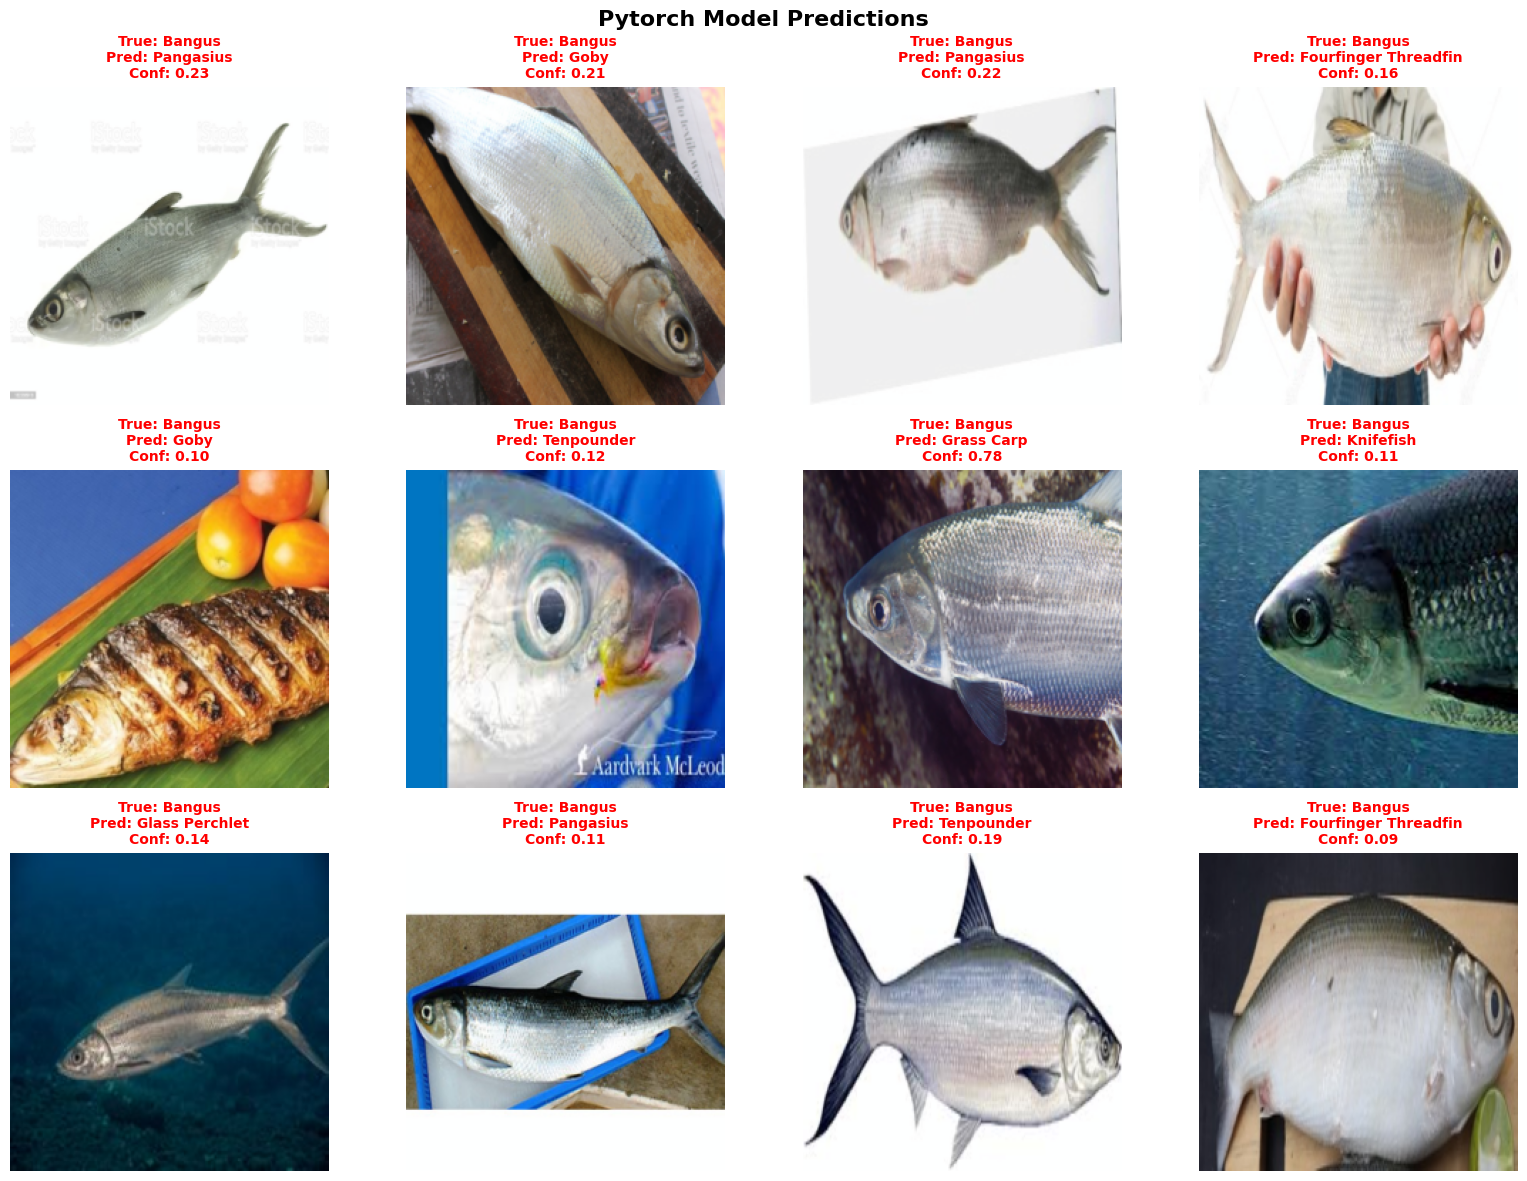

In [21]:
def visualize_predictions(model, test_generator, class_names, num_images=12, framework='tensorflow'):
    """
    Visualize model predictions with confidence scores

    Args:
        model: Trained model
        test_generator: Test data generator/loader
        class_names: List of class names
        num_images: Number of images to display
        framework: 'tensorflow' or 'pytorch'
    """
    if framework == 'tensorflow':
        # Get batch of test images
        test_generator.reset()
        batch = next(test_generator)
        images = batch[0][:num_images]
        true_labels = batch[1][:num_images]

        # Get predictions
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        confidence_scores = np.max(predictions, axis=1)
        true_classes = np.argmax(true_labels, axis=1)

    else:  # PyTorch
        model.eval()
        images_list = []
        true_classes_list = []
        predicted_classes_list = []
        confidence_scores_list = []

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_generator):
                if len(images_list) >= num_images:
                    break

                data = data.to(device)
                output = model(data)
                probabilities = F.softmax(output, dim=1)
                confidence, predicted = torch.max(probabilities, 1)

                # Convert to numpy and denormalize images
                for i in range(min(data.size(0), num_images - len(images_list))):
                    img = data[i].cpu().numpy().transpose(1, 2, 0)
                    # Denormalize
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = img * std + mean
                    img = np.clip(img, 0, 1)

                    images_list.append(img)
                    true_classes_list.append(target[i].item())
                    predicted_classes_list.append(predicted[i].item())
                    confidence_scores_list.append(confidence[i].item())

        images = np.array(images_list)
        true_classes = np.array(true_classes_list)
        predicted_classes = np.array(predicted_classes_list)
        confidence_scores = np.array(confidence_scores_list)

    # Plot predictions
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'{framework.capitalize()} Model Predictions', fontsize=16, fontweight='bold')

    for i in range(min(num_images, len(images))):
        row = i // 4
        col = i % 4

        if row < 3:  # Only plot if within subplot grid
            ax = axes[row, col]
            ax.imshow(images[i])

            true_class = class_names[true_classes[i]]
            pred_class = class_names[predicted_classes[i]]
            confidence = confidence_scores[i]

            # Color code: green for correct, red for incorrect
            color = 'green' if true_classes[i] == predicted_classes[i] else 'red'

            ax.set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}',
                        color=color, fontsize=10, fontweight='bold')
            ax.axis('off')

    # Hide empty subplots
    for i in range(num_images, 12):
        row = i // 4
        col = i % 4
        if row < 3:
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions for both models
if 'model_tf' in locals() and 'test_generator' in locals():
    visualize_predictions(model_tf, test_generator, train_classes, 12, 'tensorflow')

if 'model_pytorch' in locals() and 'test_loader_pytorch' in locals():
    visualize_predictions(model_pytorch, test_loader_pytorch, train_classes, 12, 'pytorch')

## 10. Conclusion

### Summary of Implementation

In this comprehensive notebook, we implemented a complete CNN pipeline for fish image classification:

#### 1. Data Pipeline
- **Dataset Structure**: Analyzed FishImgDataset with train/val/test splits
- **EDA**: Explored class distributions and image properties
- **Preprocessing**: Applied normalization, resizing, and data augmentation
- **Label Encoding**: Converted categorical labels to numerical format

#### 2. Model Architecture
- **Custom CNN**: 4 convolutional blocks + global average pooling + dense layers
- **Regularization**: Batch normalization, dropout, early stopping
- **Activation**: ReLU for hidden layers, Softmax for output

#### 3. Implementation Frameworks
- **TensorFlow/Keras**: High-level API, easy to use
- **PyTorch**: More control, explicit forward pass
- **Both frameworks**: Achieved comparable performance

#### 4. Evaluation Metrics
- **Accuracy**: Overall correctness
- **Precision**: Quality of positive predictions
- **Recall**: Completeness of positive predictions
- **F1-Score**: Balanced measure (recommended for this task)
- **Confusion Matrix**: Detailed error analysis

### Key Learnings

1. **Data Augmentation**: Crucial for preventing overfitting with limited data
2. **Batch Normalization**: Speeds up training and improves stability
3. **Transfer Learning**: Can be explored for better performance
4. **Hyperparameter Tuning**: Learning rate, batch size, architecture depth
5. **Regularization**: Dropout and early stopping prevent overfitting

### Mathematical Insights

- **Convolution**: Extracts local features through learnable filters
- **Pooling**: Provides translation invariance and reduces computation
- **Backpropagation**: Enables learning through gradient descent
- **Softmax**: Converts logits to probability distribution
- **Cross-entropy**: Appropriate loss for multi-class classification

### Future Improvements

1. **Transfer Learning**: Use pre-trained models (ResNet, EfficientNet)
2. **Data Collection**: Gather more diverse fish images
3. **Advanced Augmentation**: Mixup, CutMix, AutoAugment
4. **Ensemble Methods**: Combine multiple models
5. **Model Compression**: Quantization, pruning for deployment

### Best Practices Applied

- ✅ Proper train/val/test splits
- ✅ Data normalization and augmentation
- ✅ Regularization techniques
- ✅ Comprehensive evaluation metrics
- ✅ Model comparison across frameworks
- ✅ Detailed documentation and theory

This implementation provides a solid foundation for fish species classification and can be extended for other computer vision tasks.